SystemExit: 0

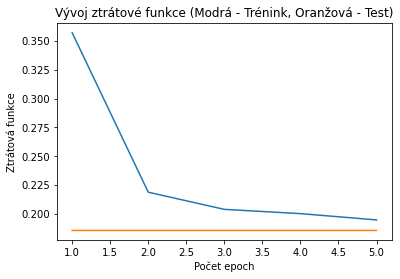

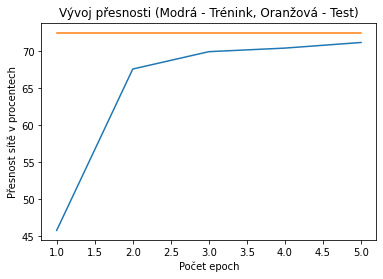

In [2]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from PyQt5 import QtWidgets, QtCore, QtGui
from PyQt5.QtWidgets import QApplication, QMainWindow, QWidget, QInputDialog, QLineEdit
from PyQt5.QtWidgets import *
from PyQt5.QtGui import *
from PyQt5.QtCore import *
import sys
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.backends.backend_qt5agg import NavigationToolbar2QT as NavigationToolbar
from PIL import Image, ImageFilter

def global_sit():
    global sit
    sit = Net()
    
def global_sit2():
    global sit
    sit = Net2()
    
def nastav_volbu1():
    global volba
    volba = 1
    
def nastav_volbu2():
    global volba
    volba = 2

def Data_mnist():

    train = datasets.MNIST("train_cisla", train = True, download = True, transform = transforms.Compose([transforms.ToTensor()]))
    test = datasets.MNIST("test_cisla", train = False, download = True, transform = transforms.Compose([transforms.ToTensor()]))

    trainset = torch.utils.data.DataLoader(train, batch_size = 10, shuffle = True)
    testset = torch.utils.data.DataLoader(test, batch_size = 10, shuffle = True)
    
    return trainset, testset

def Data_emnist():

    train = datasets.EMNIST("train_pismena", "letters",  train = True, download = True, transform = transforms.Compose([transforms.ToTensor()]))
    test = datasets.EMNIST("test_pismena", "letters", train = False, download = True, transform = transforms.Compose([transforms.ToTensor()]))
    
    trainset = torch.utils.data.DataLoader(train, batch_size = 10, shuffle = True)
    testset = torch.utils.data.DataLoader(test, batch_size = 10, shuffle = True)

    return trainset, testset

def Adam_and_Eve(x):
  
    optimizer = optim.Adam(x.parameters(), lr = 0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)

    return optimizer

def Correct_funkce(x, y):
    
    vysledek = 0
    for i in range(10):
        if torch.argmax(x[i]) == y[i]:
            vysledek += 1
        else:
            vysledek += 0
        
    return vysledek

def confusion_matrix():
    if volba == 1:
        nmbr = 26
        trainset, testset = Data_emnist()
        
    else:
        nmbr = 10
        trainset, testset = Data_mnist()
        
    conf = np.zeros((nmbr, nmbr))
    
    for data in testset:
        X, lab = data
        output = sit(X.view(-1, 28*28))
        for i in range(10):
            if volba == 1:
                conf[lab[i]-1][torch.argmax(output[i])-1] += 1
            else:
                conf[lab[i]][torch.argmax(output[i])] += 1     
    return conf

def Snimek_na_tensor(soubor):
    im = Image.open(soubor).convert('L')
    width, height = im.size
    
    
    if width == 28 and height == 28:
    
        list_pixelu = list(im.getdata())
        list_pixelu_filtr = []
        for pixel in list_pixelu:
                list_pixelu_filtr.append(((255 - pixel) * 1.0)/255.0 )

        obr_tenzor = torch.tensor(list_pixelu_filtr)

        return False, obr_tenzor

    else:
        
        return True, 1
                
def Pocet_epoch_funkce(epochy):
    global pocet_epoch
    pocet_epoch = []
    pocet_epoch_presnost = []
    for i in range(epochy):
      pocet_epoch.append(i+1)
      pocet_epoch_presnost.append(i+1)         

class MyWindow(QMainWindow):

    def __init__(self):

        super(MyWindow, self).__init__()
    
        xpos = 200
        ypos = 200
        width = 800
        height = 800
        
        self.conf_matrix_okno = None
        self.loss = None
        self.presnost = None

        self.setGeometry(xpos,ypos,width,height)
        self.setWindowTitle("Machine learning")
        self.Obrazovka_1()

    def Obrazovka_1(self):

        self.popis = QtWidgets.QLabel(self)
        self.popis.setFont(QFont("Times", 24))
        self.popis.setText("Vítejte v programu!")
        self.popis.setGeometry(245, 50, 500,50)
        

        self.popis2 = QtWidgets.QLabel(self)
        self.popis2.setFont(QFont("Times", 18))
        self.popis2.setText("Vyberte si prosím, kterou datovou sadu chcete využít.")
        self.popis2.setGeometry(100, 200, 700, 50)
        
        self.popis3 = QtWidgets.QLabel(self)
        self.popis3.setFont(QFont("Times", 18))
        
        self.b1 = QtWidgets.QPushButton(self)
        self.b1.setGeometry(100, 300, 200, 100)
        self.b1.setText("MNIST (čísla)")
        self.b1.clicked.connect(self.GUI_dataset2)
        
        self.b2 = QtWidgets.QPushButton(self)
        self.b2.setGeometry(450, 300, 200, 100)
        self.b2.setText("EMNIST (písmena)")
        self.b2.clicked.connect(self.GUI_dataset1)
        
        self.b3 = QtWidgets.QPushButton(self)
        self.b3.setGeometry(100, 500, 200, 100)
        self.b3.setText("Nahrát do programu vlastní obrázek")
        self.b3.hide()
        
        self.b4 = QtWidgets.QPushButton(self)
        self.b4.setGeometry(450, 500, 200, 100)
        self.b4.setText("Vytvořit confusion matrix")
        self.b4.hide()
        
        self.b5 = QtWidgets.QPushButton(self)
        self.b5.setGeometry(300, 350, 200, 100)
        self.b5.setText("Zpět")
        self.b5.clicked.connect(self.GUI_dataset2)
        self.b5.hide()
        
        self.update()
        
        self.soucasna_epocha = 1
        self.soucasna_presnost = 0
        
    def Input_cancel(self):
        self.b1.show()
        self.b2.show()
        
        self.popis.setFont(QFont("Times", 24))
        self.popis.setText("Vítejte v programu!")
        self.popis.setGeometry(245, 50, 500,50)
        
        self.popis2.setFont(QFont("Times", 18))
        self.popis2.setText("Vyberte si prosím, kterou datovou sadu chcete využít.")
        self.popis2.setGeometry(100, 200, 700, 50)
        
        self.popis3.setText("")
        self.update()
        
        
    def GUI_dataset2(self): 
        self.b1.hide()
        self.b2.hide()
        self.popis.setText("Vyčkejte prosím, než proběhne fáze učení a testování sítě.")
        self.popis.setGeometry(25, 100, 800,50)
        self.popis.setFont(QFont("Times", 22))
        self.popis2.setText("Právě probíhá {}. epocha učení.".format(self.soucasna_epocha))
        self.popis2.setGeometry(200, 300, 700, 50)
        self.popis3.setText("Současná přesnost sítě je {} %.".format(self.soucasna_presnost))
        self.popis3.setGeometry(185, 500, 700, 50)
        self.update()
        
        global_sit()
        nastav_volbu2()
        
        self.get_epochs()
        
    def GUI_dataset1(self): 
        self.b1.hide()
        self.b2.hide()
        self.popis.setText("Vyčkejte prosím, právě probíhá fáze učení a testování sítě.")
        self.popis.setGeometry(25, 100, 800,50)
        self.popis.setFont(QFont("Times", 22))
        self.popis2.setText("Právě probíhá {}. epocha učení.".format(self.soucasna_epocha))
        self.popis2.setGeometry(200, 300, 700, 50)
        self.popis3.setText("Současná přesnost sítě je {} %.".format(self.soucasna_presnost))
        self.popis3.setGeometry(175, 500, 700, 50)
        self.update()
        
        global_sit2()
        nastav_volbu1()
        
        self.get_epochs()
        
    def get_epochs(self):
        x, okPressed = QInputDialog.getInt(self, "Počet epoch","Zvolte prosím, kolik epoch učení má síť provést (Doporučené množství: 5):", 0, 0, 100, 1)
        if okPressed:
            self.epochy = x
            self.cykly()
        else:
            self.Input_cancel()
        
    def cykly(self):
        Pocet_epoch_funkce(self.epochy)
        self.datatraintest = DataTrainTestMNIST(self.epochy)
        self.datatraintest.start()
        self.datatraintest.finished.connect(self.set_buttons)
        self.datatraintest.vrat_epochu.connect(self.nastav_epochu)
        self.datatraintest.vrat_procento.connect(self.nastav_procento)
        self.datatraintest.vrat_loss_train.connect(self.nastav_loss_train)
        self.datatraintest.vrat_presnost_train.connect(self.nastav_presnost_train)   
        self.datatraintest.vrat_loss_test.connect(self.nastav_loss_test)
        self.datatraintest.vrat_presnost_test.connect(self.nastav_presnost_test)
        
    def nastav_epochu(self, x):
        if x < self.epochy:
            self.popis2.setText("Právě probíhá {}. epocha učení.".format(x+1))
            self.popis2.setGeometry(200, 300, 700, 50)
        else: 
            self.popis2.setText("Síť je aplikována pro testovací data.".format(x+1))
        self.update()
        
    def nastav_procento(self, x):
        self.popis3.setText("Současná přesnost sítě je {} %.".format(round(x, 2)))  
        self.update()
    
    def nastav_loss_train(self, x):
        self.loss_train = x
        
    def nastav_presnost_train(self, x):
        self.presnost_train = x
        
    def nastav_loss_test(self, x):
        self.loss_test = x
        
    def nastav_presnost_test(self, x):
        self.presnost_test = x
        
    def set_buttons(self):
        
        self.b1.clicked.disconnect()
        self.b2.clicked.disconnect()
        
        self.b1.setText("Zobrazit graf ztrátové funkce")
        self.b1.clicked.connect(self.Graf_ztraty)
        self.b1.show()
        
        
        self.b2.setText("Zobrazit graf vývoje přesnosti")
        self.b2.clicked.connect(self.Graf_presnosti_GUI)
        self.b2.show()
        
        self.b3.show()
        self.b3.clicked.connect(self.vlastni_snimek_GUI)
        
        self.b4.show()
        self.b4.clicked.connect(self.confusion_matrix_GUI)
        
        self.update()
        
        self.druha_faze()
        
    def druha_faze(self):
        
        self.b1.show()
        self.b2.show()
        self.b3.show()
        self.b4.show()
        self.b5.hide()
        
        self.popis.setText("Neuronová síť je připravena k použití.")
        self.popis.setGeometry(100, 50, 800, 50)
        self.popis.setFont(QFont("Times", 24))
        
        self.popis2.setText("Zvolte prosím, jakou akci má aplikace dále provést.")
        self.popis2.setGeometry(100, 200, 700, 50)
        self.popis2.setFont(QFont("Times", 18))
        
        self.popis3.setGeometry(175, 700, 700, 50)
        
        
        self.update()
        
    def confusion_matrix_GUI(self):
    
        if self.conf_matrix_okno is None: 
            self.conf_matrix_okno = Ukaz_conf_matrix()
        self.conf_matrix_okno.show()
        
    def vlastni_snimek_GUI(self, soubor = None):
        self.b1.hide()
        self.b2.hide()
        self.b3.hide()
        self.b4.hide()
        
        self.popis.setText("Vyberte prosím požadovaný obrázek.")
        self.popis.setGeometry(115, 50, 800, 50)
        self.popis2.setText("Varování: Nahraná fotografie musí být ve formátu 28*28 pixelů.")
        self.popis2.setGeometry(150, 200, 800, 50)
        self.popis2.setFont(QFont("Times", 12))
        
        self.update()
        
        if not soubor:
            soubor, _ = QFileDialog.getOpenFileName(self, 'Vyberte obrázek', QDir.currentPath(), 'Images (*.png *.jpg)')
            if not soubor:
                return
        
        Je_pravda, obr_tenzor = Snimek_na_tensor(soubor)
        if Je_pravda == True:
            self.b5.clicked.disconnect()
            self.b5.clicked.connect(self.druha_faze)
            self.b5.show()

            self.popis2.setFont(QFont("Times", 12))
            self.popis2.setGeometry(200, 200, 800, 50)
            self.popis2.setText("Špatné rozměry snímku, rozměry musí být 28*28 pixelů")
            self.update()
        else:
            vysledek = torch.argmax(sit(obr_tenzor.view(-1, 28*28)))
            self.popis.setGeometry(40, 50, 800, 50)
            if volba == 1:
                abcd = ["a", "b","c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]
                self.popis.setText("Síť předpokládá, že znak na snímku je písmeno {}.".format(abcd[vysledek-1]))
            else:
                self.popis.setText("Síť předpokládá, že znak na snímku je číslo {}.".format(vysledek))

            self.b5.clicked.disconnect()
            self.b5.clicked.connect(self.druha_faze)
            self.b5.show()

            self.popis2.setFont(QFont("Times", 8))
            self.popis2.setGeometry(25, 200, 800, 50)
            self.popis2.setText("")
            self.update()

        
    def Graf_ztraty(self):
        
        if self.loss is None: 
            self.loss = Ukaz_loss()
        self.loss.show()
    
    def Graf_presnosti_GUI(self):
        
        if self.presnost is None: 
            self.presnost = Ukaz_presnost()
        self.presnost.show()
        
class DataTrainTestMNIST(QThread):
    
    vrat_epochu = pyqtSignal(int)
    vrat_procento = pyqtSignal(float)
    vrat_loss_train = pyqtSignal(list)
    vrat_presnost_train = pyqtSignal(list)
    vrat_loss_test = pyqtSignal(list)
    vrat_presnost_test = pyqtSignal(list)
    
    def __init__(self, epochy, parent=None):
        QThread.__init__(self, parent)
        self.epochy = epochy
    def run(self):
        
        if volba == 2:
            self.trainset, self.testset = Data_mnist()
        else:
            self.trainset, self.testset = Data_emnist()
        
        optimizer = Adam_and_Eve(sit)
        
        global loss_train
        global presnost_train
        
        loss_train = []
        presnost_train = []
        
        for i in range(self.epochy):
            loss_overall = 0
            correct = 0
            total = 0
            for item in self.trainset:
                obr, lab = item
                sit.zero_grad()
                output = sit(obr.view(-1, 28*28))
                loss = func.nll_loss(output, lab)
                correct += Correct_funkce(output, lab)
                total += 10
                loss.backward()
                optimizer.step()
                loss_overall += loss
            procento = correct/(total/100)
            loss_train.append(loss_overall/60000)
            presnost_train.append(correct/(total/100))
            self.vrat_epochu.emit(i+1)
            self.vrat_procento.emit(procento)
            
        self.vrat_loss_train.emit(loss_train)
        self.vrat_presnost_train.emit(presnost_train)     
        
        global loss_test
        global presnost_test
        
        loss_test = []
        presnost_test = []
        
        for i in range(self.epochy):
            loss_celkova = 0
            correct = 0
            total = 0
            for item in self.testset:
              obr, lab = item
              output = sit(obr.view(-1, 28*28))
              correct += Correct_funkce(output, lab)
              total += 10
              loss = func.nll_loss(output, lab)
              loss_celkova += loss
            procento = correct/(total/100)
            presnost_test.append(procento)
            loss_test.append(loss_celkova/10000)
                    
        self.vrat_loss_test.emit(loss_test)
        self.vrat_presnost_test.emit(presnost_test)
        
        
class Ukaz_conf_matrix(QWidget):
    def __init__(self):
        super().__init__()
        
        
        self.setWindowTitle('Confusion matrix')
        if volba == 1:
            self.setGeometry(50, 50, 1125, 850)
        else:
            self.setGeometry(50, 50, 800, 380)
        self.conf_matrix()
   
        self.layout = QVBoxLayout()
        self.layout.addWidget(self.tableWidget)
        self.setLayout(self.layout)
   
        self.show()
   
    def conf_matrix(self):
        
        conf = confusion_matrix()
        
        if volba == 1:
            nmbr = 26
            columns = ["a", "b","c", "d", "e", "f", "g", "h", "i", "j", "k", "l", "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]
        else:
            nmbr = 10
            columns = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
        
        
        self.tableWidget = QTableWidget()
        self.tableWidget.setColumnCount(nmbr)  
        self.tableWidget.setRowCount(nmbr)
        self.tableWidget.setHorizontalHeaderLabels(columns)
        self.tableWidget.setVerticalHeaderLabels(columns)
        
        for i in range(nmbr):
            for j in range(nmbr): 
                jozef = str(conf[i][j])
                self.tableWidget.setItem(i, j, QTableWidgetItem(jozef))
                
        self.tableWidget.horizontalHeader().setStretchLastSection(True)
        self.tableWidget.horizontalHeader().setSectionResizeMode(
            QHeaderView.Stretch)
        
class Ukaz_loss(QWidget):
    def __init__(self):
        super().__init__()
        self.setGeometry(50, 50, 400, 290)
        
        Graf = Graf_loss(self)
        
class Ukaz_presnost(QWidget):
    def __init__(self):
        super().__init__()
        self.setGeometry(50, 50, 400, 290)
        
        Graf = Graf_presnost(self)

class Graf_loss(FigureCanvas):
    def __init__(self, parent):
        fig, self.ax = plt.subplots()
        super().__init__(fig)
        
        self.setParent(parent)
        
        self.ax.plot(pocet_epoch, loss_train)
        self.ax.plot(pocet_epoch, loss_test)
        
        self.ax.set(xlabel = "Počet epoch", ylabel = "Ztrátová funkce", title = "Vývoj ztrátové funkce (Modrá - Trénink, Oranžová - Test)")
        
        self.ax.grid
        
class Graf_presnost(FigureCanvas):
    def __init__(self, parent):
        fig, self.ax = plt.subplots()
        super().__init__(fig)
        
        self.setParent(parent)
        
        self.ax.plot(pocet_epoch, presnost_train)
        self.ax.plot(pocet_epoch, presnost_test)
        
        self.ax.set(xlabel = "Počet epoch", ylabel = "Přesnost sítě v procentech", title = "Vývoj přesnosti (Modrá - Trénink, Oranžová - Test)")
        
        self.ax.grid
        
        
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.vrstva1 = nn.Linear(784, 64)
    self.vrstva2 = nn.Linear(64, 64)
    self.vrstva3 = nn.Linear(64, 64)
    self.vrstva4 = nn.Linear(64, 64)
    self.vrstva5 = nn.Linear(64, 10)

  def forward(self, inf):
    
    inf = func.relu(self.vrstva1(inf))
    inf = func.relu(self.vrstva2(inf))
    inf = func.relu(self.vrstva3(inf))
    inf = func.relu(self.vrstva4(inf))
    inf = func.log_softmax(self.vrstva5(inf), dim = 1)

    return inf

class Net2(nn.Module):
  def __init__(self):
    super().__init__()

    self.vrstva1 = nn.Linear(784, 64)
    self.vrstva2 = nn.Linear(64, 64)
    self.vrstva3 = nn.Linear(64, 64)
    self.vrstva4 = nn.Linear(64, 64)
    self.vrstva5 = nn.Linear(64, 27)

  def forward(self, inf):
    
    inf = func.relu(self.vrstva1(inf))
    inf = func.relu(self.vrstva2(inf))
    inf = func.relu(self.vrstva3(inf))
    inf = func.relu(self.vrstva4(inf))
    inf = func.log_softmax(self.vrstva5(inf), dim = 1)

    return inf 

if __name__ == '__main__':
    app = QApplication(sys.argv)

    win = MyWindow()

    win.show()

    sys.exit(app.exec_())  
        